# Introduction to Reinforcement Learning: the retail store management problem

This notebook presents an example of a problem that can be cast as a Reinforcement Learning problem.

We first explain how to model the dynamics of the problem as a finite Markov Decision Process.

In most subsequent sections, we then simplify the problem and assume that the environment is _known_ (i.e., we assume that we know the transition probabilities of the MDP). In this setting we illustrate stochastic control methods (Policy Evaluation, Policy Iteration, and Value Iteration) that are useful to compute policies with maximum cumulative discounted rewards.

The last part of the notebook deals with the more challenging Reinforcement Learning problem, where the environment is _unknown_ but the reward-accumulating goal is similar. We implement the Q-learning algorithm.

For a more advanced introduction to RL, we refer the reader to:
- Sutton and Barto's book: "Reinforcement Learning: an introduction", https://web.stanford.edu/class/psych209/Readings/SuttonBartoIPRLBook2ndEd.pdf
- Erwan Le Pennec's summary of Sutton and Barto's book: http://www.cmap.polytechnique.fr/~lepennec/files/RL/Sutton.pdf
- Emmanuel Rachelson's course with notebooks: https://github.com/erachelson/RLclass

In [27]:
%matplotlib inline
from matplotlib.pyplot import *
from math import *
from numpy import *
from numpy.random import *
from scipy.misc import *
from scipy.stats import *
import copy

## The retail store management problem

The problem we consider is the following. As a store manager, you are responsible for maintaining a stock of products (units) in a little warehouse. Every month, you can order new products to increase your stock, and you can sell products to clients (we assume for simplicity that all transactions happen at the end of the month). Products that are sold generate revenue, but products in the warehouse also generate storage costs, along with transportation costs.

Imagine your only degree of freedom is the number of new units you order every month to increase your stock. How should you proceed so as to maximize your total revenue?

### Notation

At each month $t\geq 1$, consider 
- $x_t$: number of units in the warehouse (entrepôt) at the beginning of the month
- $a_t$: action = number of units ordered for the end of the month
- $D_t$: demand for that month (assume units are all sold at the very end of the month, after receiving additional units)

### Problem parameters
- $p$: selling price per unit. 
- $c$: cost per unit (buying price) with $c<p$. 
- $h$: storage cost per unit. 
- $K$: overall transportation cost. 

### Problem constraints

- If the demand exceeds the number of available units, that is  $D_t > x_t + a_t,$
then some clients are left aside. 
- Maximum storage capacity is of $M$ units. 

### Casting this setting as a Markov Decision Process
- State space: $\mathcal{S}=\{0,1,\ldots,M\}$. 
- Available actions from state $x\in\mathcal{S}$: $\mathcal{A}(x)=\{0,1,\ldots,M-x\}$. 
- Dynamics: 
    - the demand is random, more precisely: $D_t \overset{i.i.d.}{\sim} p_D$.
    - next state: $x_{t+1} = (\min\{x_t+a_t,M\}-D_t)_+$.
    - reward: $R_{t+1}$ given by
$$R_{t+1} = p\times \underbrace{\min\{D_t,\min\{x_t+a_t,M\}\}}_{(A)} - c\times (\underbrace{\min\{x_t+a_t,M\}-x_t}_{(B)}) - \underbrace{h\times x_t}_{(C)} -\underbrace{K\times \mathbf{1}_{a_t>0}}_{(D)},$$
where 
        - $\min\{x_t+a_t,M\}$: what we have before selling, 
        - $(C)$: storing cost, 
        - $(D)$: fixed transportation cost. 

**Questions:** 
- Explain why the next state formula involves a positive part $(\cdot)_+$.
- Explain what $(A)$ and $(B)$ correspond to. 
    
    ANS:
    - A = selling cost
    - B = buying cost 


## Simulation of the Markov Decision Process (MDP)

### Setting inventory parameters

In [28]:
M = 15 # maximum storage capacity
gamma = 0.99 # discount 

p = 1 # selling price per unit 
c = 0.5 # cost per unit (buying price s.t. c<p)
h = 0.3 # storage cost per unit
K = 0.8 # overall transportation cost

### Demand probability distribution

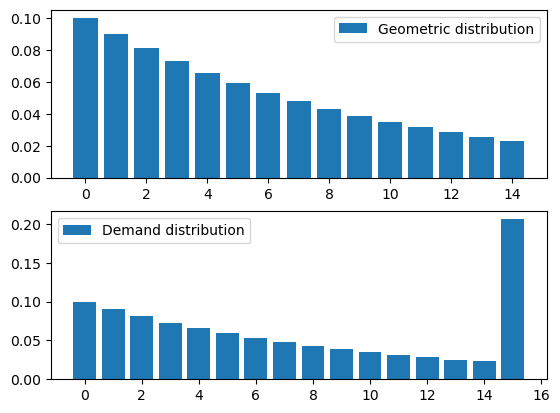

In [59]:
subplot(2,1,1)
# pD = [pD(0),pD(1),..,pD(M)]
q = 0.1
pD = [q*(1-q)**k for k in range(M)] # geometric distribution
bar(range(M),pD, label="Geometric distribution")
legend()

subplot(2,1,2)
pD.append(1 - sum(pD)) # li sumem la resta de la distribució
bar(range(M+1),pD, label="Demand distribution")
legend()

la veritable funció de la demanda és una distribució geometrica, però 

In [53]:
# random demand (drawn from p, starting at 0)
def rdemand(p):
    return(sum(rand()>cumsum(p)))

**Question:** Explain why the function `rdemand` generates a random variable from the distribution $p_D$. (How would you check it numerically?)


(array([0.09974, 0.09063, 0.08291, 0.07277, 0.06415, 0.05843, 0.05243,
        0.04749, 0.04221, 0.03793, 0.03509, 0.032  , 0.0288 , 0.02524,
        0.02317, 0.20701]),
 array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5,
        10.5, 11.5, 12.5, 13.5, 14.5, 15.5]),
 <BarContainer object of 16 artists>)

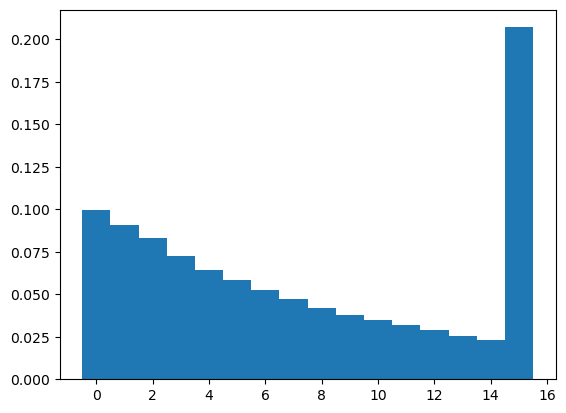

In [54]:
xx = [rdemand(pD) for k in range(10**5)]
hist(xx,bins=linspace(-0.5,15.5,17),density=True)

### Reward function

In [31]:
def reward(x,a,d,K=0.8,c=0.5,h=0.3,p=1):
    return(p*min(d,x+a,M) - c*max(0,min(x+a,M)-x) - h*x - K*(a>0))

In [32]:
reward(12,1,10)-(10-0.5-0.3*12-0.8)

0.0

### Transition function

In [33]:
def nextState(x, a, d):
    return(max(0, min(x+a, M)-d))

In [34]:
nextState(10,10,8)

7

### Simulating the inventory sales


In [35]:
# pi: deterministic policy (mapping state x --> action pi(x))
# n: nb of iterations
def simu(n, pi):
    R = zeros(n) # rewards over n iterations
    X = M # start with M units in stock
    for t in range(n):
        D = rdemand(pD); # random demand ~ pD
        R[t] = reward(X, pi[X], D) # compute the reward
        X = nextState(X, pi[X], D) # compute the next state
    return(R)

**Example (policy $\pi_1$):** always order 2 units, whatever what we have in stock


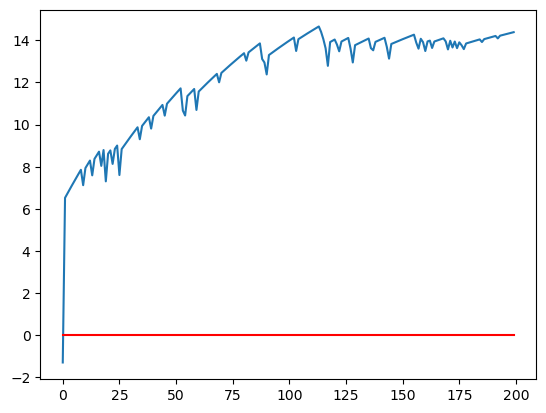

In [60]:
n = 200
pi1 = [2]*(M+1) # pi1(x) = 2 for all x=0,...,M

# simulation
R = simu(n, pi1)
V = cumsum([R[k] * gamma**k for k in range(n)])
plot(range(n), V)
plot([0,n-1],[0,0],'r')

**Questions:**
- What is plotted here?
- Why isn't the curve increasing?
- Simulate the total discounted reward for the policy $\pi_2$ that always buys a number of units in order to reach the maximum storage capacity. 
- Which policy would you choose among these two policies? Explain why. 

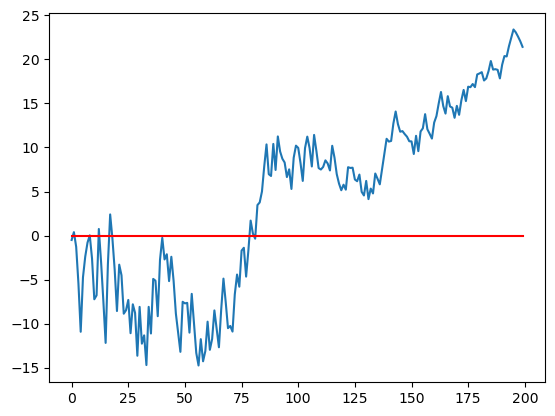

In [61]:
#Policy pi2

n = 200
pi2 = [M-x for x in range(M+1)] # pi2(x) = M-x for all x=0,...,M

# simulation
R = simu(n, pi2)
V = cumsum([R[k] * gamma**k for k in range(n)])
plot(range(n), V)
plot([0,n-1],[0,0],'r')

In [38]:
# We can compare pi1 and pi2 by estimating their values from state x=M
# i.e., we estimate the expected total discounted reward starting from x=M

n = 200

nMC = 10**3 # nb of Monte Carlo simulations
v1 = 0 # estimate for value_pi1(x=M)
v2 = 0 # estimate for value_pi2(x=M)

for experiment in range(nMC):
    R1 = simu(n, pi1)
    R2 = simu(n, pi2)
    v1 += sum([R1[k] * gamma**k for k in range(n)])/nMC
    v2 += sum([R2[k] * gamma**k for k in range(n)])/nMC
    
print(v1,v2)
# Conclusion: the second policy is much more profitable on average.

10.523253882472398 46.178898816956185


## Policy and value functions

### Transition kernel and expected reward function

We now explain how to represent the transition kernel and the expected reward function in terms of python lists.

Starting from state $x$ and playing action $a$, the expected reward is given by
$$r[x,a] := \mathbb{E}\Big[R_{t+1} \Big| S_t=x,A_t=a \Big] = \sum_{d=0}^M \textrm{reward}(x,a,d) \times \mathbb{P}(D_t=d) \,.$$
Besides, the transition probability from state $x$ to state $x'$ playing action $a$ is given by
\begin{align*}
P[x,a,x'] & :=\mathbb{P}\Big(S_{t+1}=x' \Big| S_t = x, A_t=a\Big) \\
& = \mathbb{P}\Big((\min\{S_t+A_t,M\} - D_t) _+=x' \Big| S_t = x, A_t=a\Big) \\
& = \sum_{d=0}^M \mathbf{1}_{(\min\{x+a,M\} - d) _+ = x'} \times \mathbb{P}(D_t=d) \,.
\end{align*}

In [39]:
# We store the values r[x,a] in a nested list 'rew'
rew = [[sum([reward(x, a, d)*pD[d] for d in range(M+1)]) for a in range(M+1)] for x in range(M+1)]

# We store the values P[x,a,x'] in a nested list 'trans'
trans = [[[0 for y in range(M+1)] for a in range(M+1)] for x in range(M+1)]
for x in range(M+1):
    for a in range(M+1):
        for d in range(M+1):
            trans[x][a][nextState(x, a, d)] += pD[d]

In [40]:
trans[7][2][6]

0.0729

## Policy evaluation

Bellman equation: 
$$v_{\pi}(s) = \sum_{a}\pi(a|s) \underbrace{\sum_{s',r} p(s',r|s,a) \times \Big[r+\gamma v_{\pi}(s')\Big]}_{q_\pi(s,a)} = \mathcal{T}_\pi(v_\pi)(s).$$

In what follows just below, we only consider deterministic policies, i.e., such that $\pi(a|s)=1$ for a given action $a$; we denote this action by $\pi(s)$ (slight abuse of notation). As a consequence, using the expected reward function and the transition kernel defined above,

$$ \forall s, \qquad v_{\pi}(s) = r[s,\pi(s)] + \gamma \sum_{s'} P[s,\pi(s),s'] \times v_{\pi}(s') \,.$$

This can be rewritten in matrix form as
$$\overset{\rightarrow}{v}_\pi = \overset{\rightarrow}{r} + \gamma P \overset{\rightarrow}{v}_\pi \,,$$

where $\overset{\rightarrow}{r}$ is the vector with entries given by $r[s,\pi(s)]$, and where $P$ is the matrix with entries given by $P[s,\pi(s),s']$.

This is equivalent to $$(\text{Id} - \gamma P) \overset{\rightarrow}{v}_\pi = \overset{\rightarrow}{r} \quad \Longleftrightarrow \quad \overset{\rightarrow}{v}_\pi = (\text{Id} - \gamma P)^{-1} \overset{\rightarrow}{r}.$$

In [41]:
def policyValue(pol):
    r = matrix([rew[x][pol[x]] for x in range(M+1)]).transpose() #column matrix with entries rew[x,pol(x)]
    P = matrix([[trans[x][pol[x]][y] for y in range(M+1)] for x in range(M+1)])
    v = linalg.solve(identity(M+1)-gamma*P, r)
    return(v)

<BarContainer object of 16 artists>

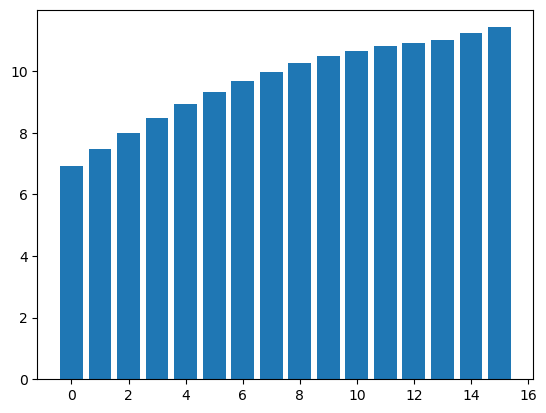

In [42]:
v1=array(policyValue(pi1)).reshape(M+1) # transforms the column matrix policyValue(pi1) into a one-dimensional array
bar(range(M+1),v1)

**Question:** 
- Compute the value of the policy `pi2` that always buys a number of units in order to reach the maximum storage capacity.
- Which policy is best? Is it consistent with your previous answers? 

<BarContainer object of 16 artists>

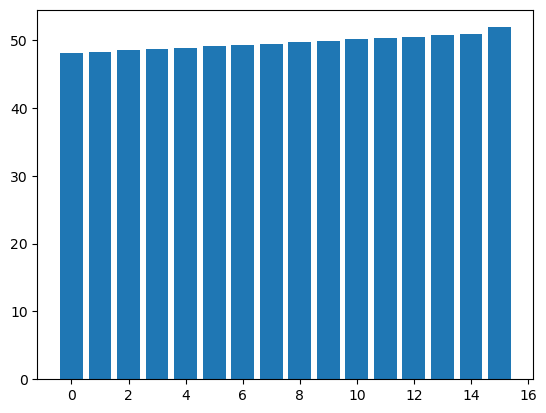

In [43]:
v2=array(policyValue(pi2)).reshape(M+1) # transforms the column matrix policyValue(pi1) into a one-dimensional array
bar(range(M+1),v2)

# Searching for the best policy

There exists an optimal policy $\pi_*$ s.t.
$$\forall \pi,\quad \forall s\in\mathcal{S}, \quad \quad v_{\pi_*}(s) \geq v_\pi(s).$$ 

Optimal policies share the same optimal value function
$$v_*(s) = v_{\pi_*}(s) = \underset{\pi}{\max}\big\{v_\pi(s)\big\},$$
and share the same optimal action-value function
$$q_*(s,a) = q_{\pi_*}(s,a) = \max_\pi\big\{q_\pi(s,a)\big\}.$$
Note that for a state-action pair $(s,a)$, this function gives the expected return for taking action $a$ in state $s$ and thererafter following an optimal policy, i.e. 
\begin{eqnarray*}
q_*(s,a) &=& \mathbb{E}\Big[R_{t+1} + \gamma v_*(S_{t+1}) \Big| S_t=s, A_t=a\Big] \\
&=& \sum_{s',r} p(s',r|s,a) \times \big[ r + \gamma v_*(s')\big].
\end{eqnarray*}

Intuitively, the value of a state under an optimal policy must equal the expected return for the best action form that state. This leads to the Bellman optimality equation:
$$v_*(s) = \max_a q_*(s,a) = \max_a \left\{ \sum_{s',r} p(s',r|s,a) \times \big[ r + \gamma v_*(s')\big]\right\} = \mathcal{T}_*(v_*)(s).$$
Note that once one has $v_*$, it is relatively easy to determine an optimal policy by 
$$\pi_*(s) = \underset{a}{\text{argmax}}q_*(s,a).$$

This leads to an iterative algorithm for approximating $v_*$ and therefore $\pi^*$, known as __Value Iteration__:
- for each step $k$, and for each action $a$, compute the action-value function 
$$q_{k}(s,a) = \sum_{s',r} p(s',r|s,a)\times \big[ r+\gamma v_k(s')\big]$$
- compute the next value function
$$v_{k+1}(s) = \mathcal{T}_*(v_k)(s) = \underset{a}{\max} \left\{ q_k(s,a) \right\}$$
and the next policy 
$$\pi_{k+1}(s) = \underset{a}{\text{argmax}}\Big\{q_k(s,a)\Big\} \,.$$

## Bellman operator

For a given value function $V$, the `BellmanOperator` function below returns the one-step update $\mathcal{T}_*(V)$ and the associated policy $\pi_V$ defined by:
$$\mathcal{T}_*(V)(s) = \max_a \left\{ \sum_{s',r} p(s',r|s,a) \times \big[ r + \gamma V(s')\big]\right\}$$
$$\pi_V(s) = \underset{a}{\text{argmax}} \left\{ \sum_{s',r} p(s',r|s,a) \times \big[ r + \gamma V(s')\big]\right\}$$


In [44]:
def BellmanOperator(V):
    newV = [0]*(M+1)
    newpol = [0]*(M+1)
    for x in range(M+1):
        # We compute Q[a] = q(x,a) for all actions a, in matrix column form:
        Q = matrix(rew[x]).transpose() + gamma * matrix(trans[x])*matrix(V).transpose()
        newV[x] = max(Q)[0,0] # max(Q) is 1*1 matrix
        newpol[x] = argmax(Q)
    return(newV,newpol)

In [45]:
V = [0]*(M+1)
for k in range(5):
    V,pol = BellmanOperator(V)
    print(pol)

[6, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[9, 8, 7, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[10, 9, 8, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[10, 9, 8, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[10, 9, 8, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


## Value iteration 


In [46]:
def valueIteration():
    count = 0
    V = [0]*(M+1)
    pol = [0]*(M+1) # buy nothing whatever the state
    oldV = [1]*(M+1)
    while max([abs(x-y) for x,y in zip(V,oldV)])>10**(-4):
        count += 1
        oldV = V # copy.deepcopy(V) not really useful here
        V,pol = BellmanOperator(V)
    return(V,pol,count)

## Finding the optimal solution by value iteration


number of iterations:  935
optimal policy:  [10, 9, 8, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
optimal value:  [118.21, 118.41, 118.61, 118.81, 119.113, 119.513, 119.88, 120.213, 120.512, 120.778, 121.01, 121.209, 121.374, 121.506, 121.604, 121.669]


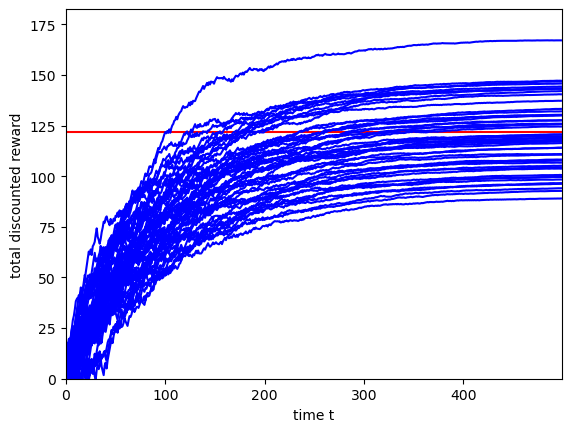

In [47]:
V,pol,count = valueIteration()

print('number of iterations: ',count)
print('optimal policy: ',pol)
print('optimal value: ',[round(x,3) for x in V])

n = int(5/(1-gamma))
vM = V[M]

plot([0,n],[vM,vM],'r')
xlim(0,n)
ylim(0,1.5*vM)
xlabel("time t")
ylabel("total discounted reward")

nplot = 50
for k in range(nplot):
    R = simu(n, pol)
    cumulR = cumsum([R[k] * gamma**k for k in range(n)])
    plot(range(n), cumulR, '-b')

## Finding the optimal policy by Policy Iteration

_Policy Iteration_ is another iterative algorithm to compute an optimal policy $\pi^*$. It is also based on the Bellman equations, and on a useful property known as Policy Improvement: if for some policy $\pi$, we consider the modified policy $\pi'$ defined for all states $s$ by
$$\pi'(s) := \underset{a}{\text{argmax}} \, q_{\pi}(s,a)$$
then $\pi'$ is an improvement over $\pi$ in the sense that $v_{\pi'}(s) \geq v_{\pi}(s)$ for all states $s$.

The Policy Iteration algorithm consists in starting from a policy $\pi_0$, and then iteratively improving it via the recursion formula
$$\pi_{k+1}(s) = \underset{a}{\text{argmax}} \, q_{\pi_k}(s,a) = \underset{a}{\text{argmax}} \, \sum_{s',r} p(s',r|s,a) \times \big[ r + \gamma v_{\pi}(s')\big]$$
(To compute the value function $v_{\pi}$ on the right-hand side, we use Policy Evaluation.)

In [48]:
pol = [0]*(M+1) # buy nothing whatever the state
for k in range(5):
    vpi = policyValue(pol)
    V,pol = BellmanOperator([vpi[i,0] for i in range(M+1)])
    print(pol)

[14, 13, 12, 11, 10, 9, 8, 7, 0, 0, 0, 0, 0, 0, 0, 0]
[11, 10, 9, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[10, 9, 8, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[10, 9, 8, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[10, 9, 8, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [49]:
def policyIteration():
    count = 0
    V = [0]*(M+1)
    pol = [0]*(M+1) # buy nothing whatever the state
    oldpol = [1]*(M+1)
    while pol!=oldpol:
        count += 1
        oldpol = pol # copy.deepcopy(pol) not really useful here
        vpi = policyValue(pol) # this a matrix, while we need a python list
        V,pol = BellmanOperator([vpi[i,0] for i in range(M+1)])
    return(V,pol,count)

number of iterations:  4
optimal policy:  [10, 9, 8, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
optimal value:  [118.22, 118.42, 118.62, 118.82, 119.122, 119.523, 119.89, 120.223, 120.522, 120.788, 121.02, 121.219, 121.384, 121.516, 121.614, 121.679]


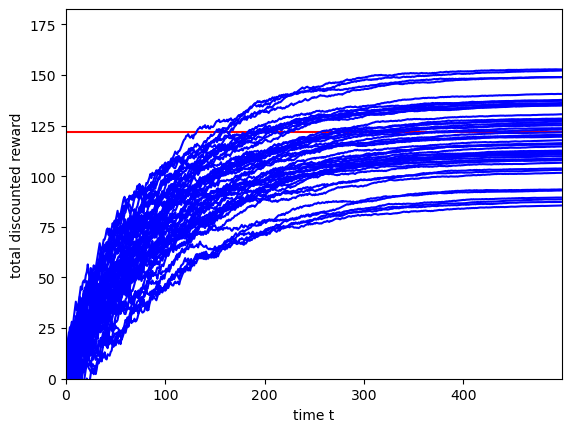

In [50]:
V,pol,count = policyIteration()

print('number of iterations: ',count)
print('optimal policy: ',pol)
print('optimal value: ',[round(x,3) for x in V])

n = int(5/(1-gamma))
vM = V[M]

plot([0,n],[vM,vM],'r')
xlim(0,n)
ylim(0,1.5*vM)
xlabel("time t")
ylabel("total discounted reward")

nplot = 50
for k in range(nplot):
    R = simu(n, pol)
    cumulR = cumsum([R[k] * gamma**k for k in range(n)])
    plot(range(n), cumulR, '-b')

## If the parameters of the MDP are unknown: Q-learning

There exist many different RL algorithms, even in the finite setting. Next, we only introduce one of them, the Q-learning algorithm.

**Q-learning:** planning by Bellman backup (off-policy TD control)

$$Q(S_t,A_t) \leftarrow Q(S_t,A_t) + \alpha \Big( R_{t+1} + \gamma \max_a Q(S_{t+1},a) - Q(S_t,A_t)\Big).$$


In [51]:
def Qlearning(n, epsilon = 0.1): # we use the epsilon-greedy policy
    Q = zeros((M+1,M+1))
    X = M # we start full
    for t in range(n):
        if rand()<epsilon:
            A = int((M+1)*rand()) # draw integer uniformly at random between 0 and M
        else:
            A = argmax(Q[X,:]) # smallest action that maximizes Q[X,]
        D = rdemand(pD)
        R = reward(X, A, D);
        nX = nextState(X, A, D);
        alpha = 1/(t+1)**0.3 #1/sqrt(t+1)
        delta = R + gamma * max(Q[nX,]) - Q[X, A]
        Q[X, A] = Q[X, A] + alpha * delta
        X = nX
    pol = [argmax(Q[x,:]) for x in range(M+1)]
    return (Q,pol)

In [52]:
Q,pol = Qlearning(50000,0.1)
print(pol)
print(policyValue(pol))

[10, 9, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 2, 0, 2, 0]
[[103.06150005]
 [103.26150005]
 [103.16938573]
 [103.65421438]
 [104.1052086 ]
 [104.52240592]
 [104.18419608]
 [105.18419608]
 [104.61245727]
 [104.86150005]
 [105.86150005]
 [106.07697008]
 [105.1077096 ]
 [106.2934991 ]
 [105.38949904]
 [106.38949904]]


Compare the policies obtained by Q-learning (note that the output is random!) with those obtained by Policy Iteration or Value Iteration.